##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Addons Networks : Sequence-to-Sequence NMT with Attention Mechanism

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/networks_seq2seq_nmt.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/addons/blob/master/docs/tutorials/networks_seq2seq_nmt.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
      <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/addons/docs/tutorials/networks_seq2seq_nmt.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview
This notebook gives a brief introduction into the ***Sequence to Sequence Model Architecture***
In this noteboook you broadly cover four essential topics necessary for Neural Machine Translation:

### 步骤
* **Data cleaning**
* **Data preparation**
* **Neural Translation Model with Attention**
* **Final Translation with ```tf.addons.seq2seq.BasicDecoder``` and ```tf.addons.seq2seq.BeamSearchDecoder```** 

The basic idea behind such a model though, is only the encoder-decoder architecture. These networks are usually used for a variety of tasks like text-summerization, Machine translation, Image Captioning, etc. This tutorial provideas a hands-on understanding of the concept, explaining the technical jargons wherever necessary. You focus on the task of Neural Machine Translation (NMT) which was the very first testbed for seq2seq models.


## Setup

In [2]:
#!pip install tensorflow-addons==0.11.2

In [196]:
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
# 此模块提供对Unicode字符数据库的访问，该字符数据库为所有Unicode字符定义字符属性。
# ref：https://cloud.tencent.com/developer/section/1371917
import unicodedata
import re
import numpy as np
import os
import io
import time

os.environ["CUDA_VISIBLE_DEVICES"]="-1"     


## Data Cleaning and Data Preparation 

You'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

---
      May I borrow this book?    ¿Puedo tomar prestado este libro?
---


There are a variety of languages available, but you'll use the English-Spanish dataset. After downloading the dataset, here are the steps you'll take to prepare the data:

### 准备工作：

1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a Vocabulary with word index (mapping from word → id) and reverse word index (mapping from id → word).
5. Pad each sentence to a maximum length. (Why? you need to fix the maximum length for the inputs to recurrent encoders)

总结下来就以下几条：
1. 为每个句子加一个开始和结束标签；
2. 清除特殊字符；
3. word embedding：创建单词到id编码的映射以及反映射；
4. 为每个序列设定一个最大长度，也可以理解为步长。为了循环编码器的输入工作，

## Step1: 首先下载数据集，建议找个网络较好的地方

In [197]:
'''
tf.keras.utils.get_file的作用主要是直接从URL下载资源
tf.keras.utils.get_file(
    fname, # 文件名，如果指定了绝对路径"/path/file.txt",则文件将会保存到该位置
    origin, # url地址
    untar=False, # 是否需要解压缩，已被extract替代
    md5_hash=None, # MD5哈希值,用于数据校验，支持sha256和md5哈希
    file_hash=None, # 下载后的文件的期望哈希字符串。 支持 sha256 和 md5 两个哈希算法。
    cache_subdir='datasets', # 用于缓存数据的文件夹，若指定绝对路径"/path/folder"则将存放在该路径下
    hash_algorithm='auto', # 选择文件校验的哈希算法，可选项有'md5', 'sha256', 和'auto'. 默认'auto'自动检测使用的哈希算法
    extract=False,# 若为True则试图提取文件，例如tar或zip 
    archive_format='auto', # 试图提取的文件格式，可选为'auto', 'tar', 'zip', 和None.
    cache_dir=None # 文件缓存后的地址，若为None，则默认存放在根目录的.keras文件夹中
)
'''
def download_nmt():
    path_to_zip = tf.keras.utils.get_file(
    'cmn-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/cmn-eng.zip',
    extract=True)

    path_to_file = os.path.dirname(path_to_zip)+"/cmn-eng/cmn.txt"
    return path_to_file


In [198]:
#download_nmt()

In [199]:
#无需下载
file_path = r'./dataset/cmn-eng/cmn.txt'

### Define a NMTDataset class with necessary functions to follow Step 1 to Step 4. 
The ```call()``` will return:
1. ```train_dataset```  and ```val_dataset``` : ```tf.data.Dataset``` objects
2. ```inp_lang_tokenizer``` and ```targ_lang_tokenizer``` : ```tf.keras.preprocessing.text.Tokenizer``` objects 

### 分词器 tf.keras.preprocessing.text.Tokenizer

## (建议参考) https://zhuanlan.zhihu.com/p/342948279

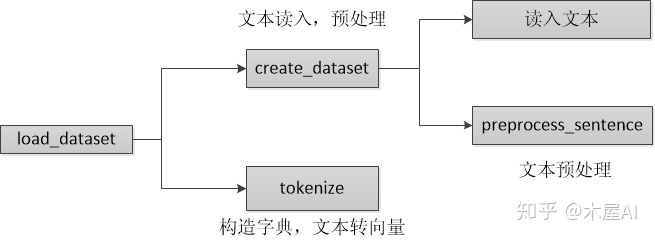

In [200]:
class NMTDataset:
    def __init__(self, problem_type='en-cmn'):
        self.problem_type = 'en-cmn' # 英语转普通话
        self.inp_lang_tokenizer = None
        self.targ_lang_tokenizer = None
    

    def unicode_to_ascii(self, s):
        # unicodedata.normalize('NFD', s)
        # 返回Unicode字符串unistr的常规表单形式。表单的有效值为'NFC'，'NFKC'，'NFD'和'NFKD'。
        # unicodedata.category(unichr)
        # 以字符串形式返回分配给Unicode字符unichr的常规类别。
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    
    # 把句子按字分开，不破坏英文结构,，只处理中文结构
    # 例如： "我爱tensorflow" -> "['我', '爱', 'tenforflow']"
    def preprocess_sentence_chinese(self,sent):
        # 首先分割 英文 以及英文和标点
        # \w 用于匹配字母，数字或下划线字符，等价于“[A-Za-z0-9_]”
        # \W 用于匹配所有与\w不匹配的字符；
        pattern_char_1 = re.compile(r'([\W])')
        parts = pattern_char_1.split(sent)
        parts = [p for p in parts if len(p.strip())>0]
        # 分割中文
        # \u4e00-\u9fa5判断是否为中文
        pattern = re.compile(r'([\u4e00-\u9fa5])')
        chars = pattern.split(sent)
        chars = [w for w in chars if len(w.strip())>0]
        out_chn = " ".join(chars)
        return '<start> ' + out_chn + ' <end>'
    
    ## 处理英文结构，以空格间隔
    def preprocess_sentence_english(self, w):
        #w = self.unicode_to_ascii(w.lower().strip())

        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        # 利用正则表达式划分句子
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        return '<start> ' + w + ' <end>'
    
    def create_dataset(self, path, num_examples):
        # path : path to spa-eng.txt file
        # num_examples : Limit the total number of training example for faster training (set num_examples = len(lines) to use full data)
        # 数据集一行就是一个样本。txt文档会被分为三列，
        # 数据集一行就是一个样本。可以看到会被分为三列，第一列是英文，第二列是英文对应的中文翻译，第三列我们不需要，直接丢掉就行了。
        # create_dataset的功能就是读入这样的文本，处理之后分别返回处理之后的英语-中文句子列表。
        lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
        # 英文文本
        english_words = []
        # 中文文本
        chinese_words = []
        
        for l in lines[:num_examples]:
            word_arrs = l.split('\t')
            if len(word_arrs) < 2:
                continue
            english_w = self.preprocess_sentence_english(word_arrs[0])
            chinese_w = self.preprocess_sentence_chinese(word_arrs[1])
            english_words.append(english_w)
            chinese_words.append(chinese_w)
        # 返回[('<start> Hi .  <end>', '<start> 嗨 。 <end>')]
        return chinese_words,english_words

    # 构建id-word对应关系
    def tokenize(self, lang):
        # lang = list of sentences in a language
        
        # print(len(lang), "example sentence: {}".format(lang[0]))
        # oov_token: 如果给出，它将被添加到 word_index 中，并用于在 text_to_sequence 调用期间替换词汇表外的单词。
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
        lang_tokenizer.fit_on_texts(lang)

        ## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
        ## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
        tensor = lang_tokenizer.texts_to_sequences(lang) 

        ## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences 
        ## and pads the sequences to match the longest sequences in the given input
        #  If not provided,sequences will be padded to the length of the longest individual sequence
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, lang_tokenizer
    
    # load_dataset、tokenize： 创建字典、文本转向量
    def load_dataset(self, path, num_examples=None):
        # creating cleaned input, output pairs
        targ_lang, inp_lang = self.create_dataset(path, num_examples)

        input_tensor, inp_lang_tokenizer = self.tokenize(inp_lang)
        target_tensor, targ_lang_tokenizer = self.tokenize(targ_lang)
        # inp_tensor是文本转向量的结果，向量里的每个元素id对应到词典库的单词。
        # inp_tokenizer是构造的词典库，构造的方式是给每个词分配一个唯一的整数id, 
        return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

    def call(self, num_examples, BUFFER_SIZE, BATCH_SIZE):
        #file_path = download_nmt()
        input_tensor, target_tensor, self.inp_lang_tokenizer, self.targ_lang_tokenizer = self.load_dataset(file_path, num_examples)
        # 训练集：验证集 = 8:2
        input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
        # 数据集加载
        train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
        # 参数buffer_size值越大，意味着数据混乱程度也越大。
        # 先抽出BUFFER_SIZE条数据，训练数据时再随机从buffer区域内随机选择BATCH_SIZE条数据
        # 参数drop_remainder：表示在少于batch_size元素的情况下是否应删除最后一批 ; 默认是不删除。
        train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

        val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
        val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

        return train_dataset, val_dataset, self.inp_lang_tokenizer, self.targ_lang_tokenizer

In [201]:
dataset_creator = NMTDataset('en-cmn')
dataset_creator.preprocess_sentence_chinese("我爱中国！"),dataset_creator.preprocess_sentence_english("I love CHINA!")

('<start> 我 爱 中 国 ！ <end>', '<start> I love CHINA ! <end>')

In [202]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
# Let's limit the #training examples for faster training
num_examples = 30000

dataset_creator = NMTDataset('en-cmn')
# 训练集、验证集、输入英文的标记<id,word>,输出西班牙语的标记<id,word> id从1开始
train_dataset, val_dataset, inp_lang, targ_lang = dataset_creator.call(num_examples, BUFFER_SIZE, BATCH_SIZE)

In [203]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 38]), TensorShape([64, 46]))

In [204]:
inp_lang.word_index["love"]

189

In [205]:
# '<OOV>': 1,
#  '<start>': 2,
#  '<end>': 3,
#  '.': 4,
example_target_batch[:3]

<tf.Tensor: shape=(3, 46), dtype=int32, numpy=
array([[   2,    5,    6, 1051,  553,    4,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   2,    5,  143,  394,   10, 1498,   13,  408,  669,  767,  309,
         317,   17,    4,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   2,  341,  583,  265,  372,  203,    8,   46,  202,  257,   12,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]], d

### Some important parameters

In [206]:
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
# 类似于步长，每次输入、输出的长度
max_length_input = example_input_batch.shape[1]
max_length_output = example_target_batch.shape[1]

# 词嵌入层神经元个数
embedding_dim = 256
# ENcoder LSTM层输入神经元个数
units = 1024
# 每一轮迭代次数
steps_per_epoch = num_examples//BATCH_SIZE


In [207]:
print("max_length_english, max_length_chinese, vocab_size_english, vocab_size_chinese")
max_length_input, max_length_output, vocab_inp_size, vocab_tar_size

max_length_english, max_length_chinese, vocab_size_english, vocab_size_chinese


(38, 46, 6757, 3723)

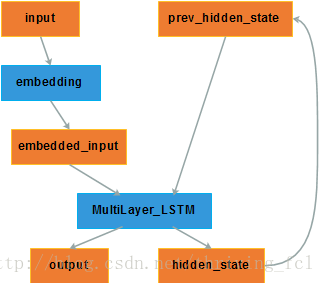

In [208]:
##### 

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
         # vocab_size: 词典表大小
         # embedding_dim：词嵌入维度 
         # enc_uints： 编码LSTM节点数量,也是输出节点数 
         # batch_sz 批大小
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        ##-------- LSTM layer in Encoder ------- ##
        self.lstm_layer = tf.keras.layers.LSTM(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')



    def call(self, x, hidden):
        x = self.embedding(x)
        # output返回的是所有步长的信息，h和c返回的是最后一步长的信息
        output, h, c = self.lstm_layer(x, initial_state = hidden)
        return output, h, c

    def initialize_hidden_state(self):
        # 参数初始化，包括一个hidden 一个cell state
        return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))] 

注意：LSTM的初始化为hidden和cell 
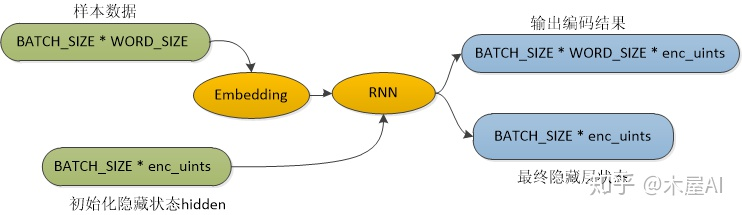

In [209]:
## Test Encoder Stack

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden) # 等价于执行call函数
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vecotr shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (64, 38, 1024)
Encoder h vecotr shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)


In [210]:
sample_output[0,max_length_input-1],sample_h[0]

(<tf.Tensor: shape=(1024,), dtype=float32, numpy=
 array([ 0.00708728,  0.00673557, -0.00238027, ..., -0.01184539,
         0.00481766,  0.02311695], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=
 array([ 0.00708728,  0.00673557, -0.00238027, ..., -0.01184539,
         0.00481766,  0.02311695], dtype=float32)>)

In [211]:
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_type='luong',memory=None):
        # vocab_size 词典大小
        # embedding_dim 词嵌入维度
        # dec_uints Decoder输出神经元数
        # batch_sz 批大小
        # attention_type 注意力机制类型
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.attention_type = attention_type
        self.memory = memory

        # Embedding Layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        #Final Dense layer on which softmax will be applied
        # 最后的softmax输出，判断应该输出哪个词汇
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Define the fundamental cell for decoder recurrent structure
        # 将Encoder输出经过attention处理之后输入到LSTMCell里面
        self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)
        '''
        tfa.seq2seq.sampler.TrainingSampler()
        简略读取输出的训练采样器。
        调用trainingSampler.initialize(input_tensors)时，取各batch中time_step=0的数据，拼接成一个数据集，返回。
        下一次调用sampler.next_inputs函数时，会取各batch中time_step++的数据，拼接成一个数据集，返回。
       '''
        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()

        # Create attention mechanism with memory = None
        # -------代码通过setup_memory()输入encoder的输出，可以通过设定memory起到相同效果-----------
        # memory可选，The memory to query，如果要加的话，一般为RNN encoder的输出。维度为[batch_size, max_time, ...]
        self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
                                                                  self.memory, self.batch_sz*[max_length_input], self.attention_type)

        # Wrap attention mechanism with the fundamental rnn cell of decoder
        self.rnn_cell = self.build_rnn_cell(batch_sz)
        
        # Define the decoder with respect to fundamental rnn cell
        # 总的来说，传进了一个rnn_cell以及一个output_layer(fc)，之后BasicDecoderOutput中的step是基于前一时刻的cell输出以及当前的输入不断计算当前的输出，
        # 之后经过output_layer最终形成序列。（类似于RNN的原理）
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler=self.sampler, output_layer=self.fc)

    
    def build_rnn_cell(self, batch_sz):
        # Wraps another RNN cell with attention
        # attention_layer_size：the depth of the attention (output) layer(s)，与“attention_layer”设置其一就好
        # AttentionWrapper在原本RNNCell的基础上在封装一层attention
        rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell, 
                                      self.attention_mechanism, attention_layer_size=self.dec_units)        
        return rnn_cell

    def build_attention_mechanism(self, dec_units, memory, memory_sequence_length, attention_type='luong'):
    # ------------- #
    # typ: Which sort of attention (Bahdanau, Luong)
    # dec_units: final dimension of attention outputs，与LSTMCell保持一致 
    # memory: encoder hidden states of shape (batch_size, max_length_input, enc_units)
    # memory_sequence_length: 1d array of shape (batch_size) with every element set to max_length_input (for masking purpose)
    
        if(attention_type=='bahdanau'):
            return tfa.seq2seq.BahdanauAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)
        else:
            return tfa.seq2seq.LuongAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)

    # The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
    # The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.
    # 使用上面的 get_initial_state 创建的初始状态包含一个 cell_state 值，该值包含来自编码器的最终状态[encoder__final_h,encoder_final_c]
    def build_initial_state(self, batch_sz, encoder_state, Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
        return decoder_initial_state


    def call(self, inputs, initial_state):
        x = self.embedding(inputs)
        # 因为最后一个输出一定会是<end>
        outputs, _, _ = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[max_length_output-1])
        # output [batch,target_length-1,target_vocab_size]
        return outputs


In [212]:
vocab_tar_size, embedding_dim, units, BATCH_SIZE,max_length_output,sample_output.shape

(3723, 256, 1024, 64, 46, TensorShape([64, 38, 1024]))

In [213]:
# Test decoder stack

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 'luong')

#初始化一个y_init，当作第一个输出的输入y
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
decoder.attention_mechanism.setup_memory(sample_output)

# [sample_h, sample_c]最后一个步长的输出hidden and cell state设定为decoder rnn_cell的初始状态
initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)


sample_decoder_outputs = decoder(sample_x, initial_state)

print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)


Decoder Outputs Shape:  (64, 45, 3723)


## Define the optimizer and the loss function

In [214]:
tf.math.equal([0,0,1],0)

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([ True,  True, False])>

In [215]:
tf.logical_not(tf.math.equal([[0,0,1],[0,1,0]],0))

<tf.Tensor: shape=(2, 3), dtype=bool, numpy=
array([[False, False,  True],
       [False,  True, False]])>

In [216]:
# default learning_rate=0.001
optimizer = tf.keras.optimizers.Adam()

# 自定义loss函数
def loss_function(real, pred):
  # real shape = (BATCH_SIZE, max_length_output)
  # pred shape = (BATCH_SIZE, max_length_output, tar_vocab_size )
    # from_logits = True 表示是原始数据，系统会帮你做softmax后再进行计算
    cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = cross_entropy(y_true=real, y_pred=pred)
    # 设定0为False，非0为True
    mask = tf.logical_not(tf.math.equal(real,0))   #output 0(False) for y=0 else output 1(True)
    mask = tf.cast(mask, dtype=loss.dtype) 
    # 为了除去0这个干扰项，因为一开始的masking以0为填充
    loss = mask* loss
    # mean的时候包括了含有0的个数
    loss = tf.reduce_mean(loss)
    return loss  

## Checkpoints (Object-based saving)

In [217]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## One train_step operations

In [218]:
# 将模型以图模式运行
'''
@tf.function
在 TensorFlow 2.0 中，推荐使用 @tf.function （而非 1.X 中的 tf.Session ）实现 Graph Execution，
从而将模型转换为易于部署且高性能的 TensorFlow 图模型。
只需要将我们希望以 Graph Execution 模式运行的代码封装在一个函数内，并在函数前加上 @tf.function 即可，
'''
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_h, enc_c = encoder(inp, enc_hidden)


        dec_input = targ[ : , :-1 ] # Ignore <end> token
        real = targ[ : , 1: ]         # ignore <start> token
        # Set the AttentionMechanism object with encoder_outputs
        decoder.attention_mechanism.setup_memory(enc_output)

        # Create AttentionWrapperState as initial_state for decoder
        decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
        pred = decoder(dec_input, decoder_initial_state)
        # pred.rnn_output Shape:  (batch, tar_length, tar_vocab_size)
        logits = pred.rnn_output
        loss = loss_function(real, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

## Train the model

encoder hiden shape: (2, 64, 1024)
Epoch 1 Batch 0 Loss 1.9128
Epoch 1 Batch 100 Loss 1.2722
Epoch 1 Batch 200 Loss 1.0410
Epoch 1 Batch 300 Loss 0.9912
Epoch 1 Loss 0.8260
Time taken for 1 epoch 195.16988062858582 sec

encoder hiden shape: (2, 64, 1024)
Epoch 2 Batch 0 Loss 0.8897
Epoch 2 Batch 100 Loss 0.9130
Epoch 2 Batch 200 Loss 0.9584
Epoch 2 Batch 300 Loss 0.8770
Epoch 2 Loss 0.6403
Time taken for 1 epoch 189.7111780643463 sec

encoder hiden shape: (2, 64, 1024)
Epoch 3 Batch 0 Loss 0.8595
Epoch 3 Batch 100 Loss 0.7679
Epoch 3 Batch 200 Loss 0.6866
Epoch 3 Batch 300 Loss 0.9013
Epoch 3 Loss 0.5368
Time taken for 1 epoch 190.029629945755 sec

encoder hiden shape: (2, 64, 1024)
Epoch 4 Batch 0 Loss 0.6423
Epoch 4 Batch 100 Loss 0.7041
Epoch 4 Batch 200 Loss 0.6586
Epoch 4 Batch 300 Loss 0.6129
Epoch 4 Loss 0.4533
Time taken for 1 epoch 190.6810290813446 sec

encoder hiden shape: (2, 64, 1024)
Epoch 5 Batch 0 Loss 0.5299
Epoch 5 Batch 100 Loss 0.6229
Epoch 5 Batch 200 Loss 0.5857
E

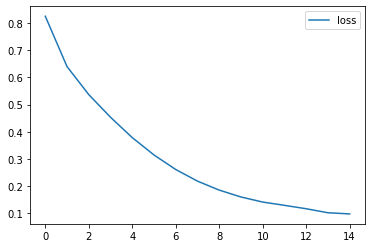

In [219]:
EPOCHS = 15

# Encoder:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden) # 等价于执行call函数

# Decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 'luong')

#初始化一个y_init，当作第一个输出的输入y
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
decoder.attention_mechanism.setup_memory(sample_output)
# [sample_h, sample_c]最后一个步长的输出hidden and cell state设定为decoder rnn_cell的初始状态
initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)
sample_decoder_outputs = decoder(sample_x, initial_state)

lossList = []
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  # 一个hidden一个cell state
  print('encoder hiden shape:',np.array(enc_hidden).shape)

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  lossList.append(total_loss / steps_per_epoch)

plt.plot(lossList,label="loss") 
plt.legend() 
plt.show()


In [220]:
batch

328

In [221]:
steps_per_epoch,num_examples,BATCH_SIZE

(468, 30000, 64)

## Use tf-addons BasicDecoder for decoding

https://www.jianshu.com/p/5ff760348eba

In [222]:
def evaluate_sentence(sentence):
    
    sentence = dataset_creator.preprocess_sentence_english(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
    inputs = tf.convert_to_tensor(inputs)
    inference_batch_size = inputs.shape[0]
    print("input shape:",inputs.shape)
    result = ''

    enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
    enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

    dec_h = enc_h
    dec_c = enc_c

    start_tokens = tf.fill([inference_batch_size], targ_lang.word_index['<start>'])
    end_token = targ_lang.word_index['<end>']
    """
    A inference sampler that takes the maximum from the output distribution.
    Uses the argmax of the output (treated as logits) and passes the
    result through an embedding layer to get the next input.
    """
    # “GreedyEmbeddingHelper”：预测阶段最常使用的Sampler，下一时刻输入是上一时刻概率最大的单词通过embedding之后的向量
    # 即贪心选择
    greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

    # Instantiate BasicDecoder object
    decoder_instance = tfa.seq2seq.BasicDecoder(cell=decoder.rnn_cell, sampler=greedy_sampler, output_layer=decoder.fc)
    # Setup Memory in decoder stack
    decoder.attention_mechanism.setup_memory(enc_out)

    # set decoder_initial_state
    decoder_initial_state = decoder.build_initial_state(inference_batch_size, [enc_h, enc_c], tf.float32)


    ### Since the BasicDecoder wraps around Decoder's rnn cell only, you have to ensure that the inputs to BasicDecoder 
    ### decoding step is output of embedding layer. tfa.seq2seq.GreedyEmbeddingSampler() takes care of this. 
    ### You only need to get the weights of embedding layer, which can be done by decoder.embedding.variables[0] and pass this callabble to BasicDecoder's call() function
    
    # get the weights of embedding layer 
    decoder_embedding_matrix = decoder.embedding.variables[0]

    outputs, _, _ = decoder_instance(decoder_embedding_matrix, start_tokens = start_tokens, end_token= end_token, initial_state=decoder_initial_state)
    return outputs.sample_id.numpy()

def translate(sentence):
    result = evaluate_sentence(sentence)
    print(result)
    result = targ_lang.sequences_to_texts(result)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

## Restore the latest checkpoint and test

In [223]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [229]:
translate("i love you")

input shape: (1, 38)
[[  5 404   8   4   3]]
Input: i love you
Predicted translation: ['我 爱 你 。 <end>']


In [238]:
translate('when are you going home?')

input shape: (1, 38)
[[  8  33  57  94  96  20 105  61  79   3]]
Input: when are you going home?
Predicted translation: ['你 什 麼 時 候 要 回 家 ? <end>']


In [231]:
targ_lang.index_word[57]

'麼'

In [239]:
translate('he is a good man.')

input shape: (1, 38)
[[ 9 11 31 37 22  4  3]]
Input: he is a good man.
Predicted translation: ['他 是 个 好 人 。 <end>']


In [240]:
# wrong translation
translate('it is a country in the world.')

input shape: (1, 38)
[[ 23  11 346 493  28  90  64   6 267  61   4   3]]
Input: it is a country in the world.
Predicted translation: ['这 是 世 界 上 最 大 的 国 家 。 <end>']


## Use tf-addons BeamSearchDecoder 

beam search不保证全局最优，但是比greedy search搜索空间更大，一般结果比greedy search要好。
greedy search 可以看做是 beam size = 1时的 beam search。

https://zhuanlan.zhihu.com/p/82829880

https://blog.csdn.net/qq_41329791/article/details/112393783

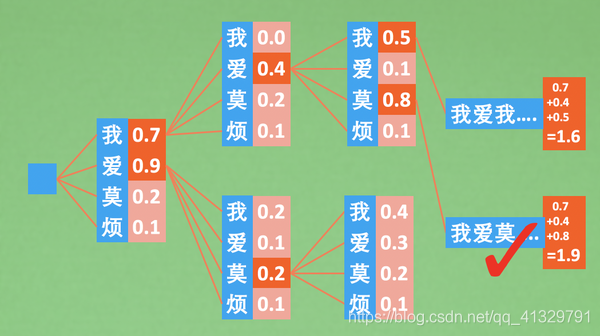

score计算方式：

The scores this step, which are the log probabilities over the output vocabulary, possibly penalized by length and attention 
coverage. When tfa.seq2seq.BeamSearchDecoder is created with output_all_scores=False (default), 
this will be a float32 Tensor of shape [batch_size, beam_width] 
containing the top scores corresponding to the predicted IDs. 
When output_all_scores=True, this contains the scores for all token IDs and has shape [batch_size, beam_width, vocab_size].


In [248]:
'''
beam search不保证全局最优，但是比greedy search搜索空间更大，一般结果比greedy search要好。
greedy search 可以看做是 beam size = 1时的 beam search。
每次预测都记录最优的3个预测，然后沿着这3个预测继续预测， 
每次后续的预测都只挑选下一步最好的3个预测。 这样加大了搜索范围，使我们有机会接触到全局较优路径。
'''
def beam_evaluate_sentence(sentence, beam_width=3):
    sentence = dataset_creator.preprocess_sentence_english(sentence) 

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
    inputs = tf.convert_to_tensor(inputs)
    inference_batch_size = inputs.shape[0]
    result = ''

    enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
    enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

    dec_h = enc_h
    dec_c = enc_c

    start_tokens = tf.fill([inference_batch_size], targ_lang.word_index['<start>'])
    end_token = targ_lang.word_index['<end>']

    # From official documentation
    # NOTE If you are using the BeamSearchDecoder with a cell wrapped in AttentionWrapper, then you must ensure that:
    # The encoder output has been tiled to beam_width via tfa.seq2seq.tile_batch (NOT tf.tile).
    # The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
    # The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.

    enc_out = tfa.seq2seq.tile_batch(enc_out, multiplier=beam_width)
    decoder.attention_mechanism.setup_memory(enc_out)
    print("beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, ",max_length_input,", 1024]] :", enc_out.shape)

    # set decoder_inital_state which is an AttentionWrapperState considering beam_width
    hidden_state = tfa.seq2seq.tile_batch([enc_h, enc_c], multiplier=beam_width)
    decoder_initial_state = decoder.rnn_cell.get_initial_state(batch_size=beam_width*inference_batch_size, dtype=tf.float32)
    decoder_initial_state = decoder_initial_state.clone(cell_state=hidden_state)

    # Instantiate BeamSearchDecoder
    decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoder.rnn_cell,beam_width=beam_width, output_layer=decoder.fc)
    decoder_embedding_matrix = decoder.embedding.variables[0]

    # The BeamSearchDecoder object's call() function takes care of everything.
    outputs, final_state, sequence_lengths = decoder_instance(decoder_embedding_matrix, start_tokens=start_tokens, end_token=end_token, initial_state=decoder_initial_state)
    # outputs is tfa.seq2seq.FinalBeamSearchDecoderOutput object. 
    # The final beam predictions are stored in outputs.predicted_id
    # outputs.beam_search_decoder_output is a tfa.seq2seq.BeamSearchDecoderOutput object which keep tracks of beam_scores and parent_ids while performing a beam decoding step
    # final_state = tfa.seq2seq.BeamSearchDecoderState object.
    # Sequence Length = [inference_batch_size, beam_width] details the maximum length of the beams that are generated


    # outputs.predicted_id.shape = (inference_batch_size, time_step_outputs, beam_width)
    # outputs.beam_search_decoder_output.scores.shape = (inference_batch_size, time_step_outputs, beam_width)
    # Convert the shape of outputs and beam_scores to (inference_batch_size, beam_width, time_step_outputs)
    final_outputs = tf.transpose(outputs.predicted_ids, perm=(0,2,1))
    beam_scores = tf.transpose(outputs.beam_search_decoder_output.scores, perm=(0,2,1))

    return final_outputs.numpy(), beam_scores.numpy()

In [249]:
def beam_translate(sentence):
  result, beam_scores = beam_evaluate_sentence(sentence)
  print(result.shape, beam_scores.shape)
  for beam, score in zip(result, beam_scores):
    print(beam.shape, score.shape)
    output = targ_lang.sequences_to_texts(beam)
    output = [a[:a.index('<end>')] for a in output]
    beam_score = [a.sum() for a in score]
    print('Input: %s' % (sentence))
    for i in range(len(output)):
      print('{} Predicted translation: {}  {}'.format(i+1, output[i], beam_score[i]))


In [250]:
beam_translate(u'i love you.')

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1,  38 , 1024]] : (3, 38, 1024)
(1, 3, 5) (1, 3, 5)
(3, 5) (3, 5)
Input: i love you.
1 Predicted translation: 我 爱 你 。   -1.9794392585754395
2 Predicted translation: 我 爱 您 。   -13.709800720214844
3 Predicted translation: 我 愛 你 。   -21.11327362060547


In [244]:
beam_translate(u'he is a good man.')

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 38, 1024)
(1, 3, 8) (1, 3, 8)
(3, 8) (3, 8)
Input: he is a good man.
1 Predicted translation: 他 是 个 好 人 。   -3.3324248790740967
2 Predicted translation: 他 是 个 好 男 人 。   -26.75017547607422
3 Predicted translation: 他 是 個 好 人 。   -33.325660705566406


In [247]:
beam_translate('it is a country in the world.')

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 38, 1024)
(1, 3, 13) (1, 3, 13)
(3, 13) (3, 13)
Input: it is a country in the world.
1 Predicted translation: 这 是 世 界 上 最 美 国 的 国 家 。   -17.759742736816406
2 Predicted translation: 这 是 世 界 上 最 大 的 国 家 。   -36.2242546081543
3 Predicted translation: 这 是 世 界 上 最 大 国 的 国 家 。   -47.567344665527344
